In [11]:
%load_ext autoreload 

import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict
from joblib import Parallel, delayed, pool
from multiprocessing import cpu_count
from IPython.display import clear_output
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm_notebook

from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from lightgbm import LGBMRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from umap import UMAP

from utils import load_dataset
N_CPU = cpu_count()
import warnings
warnings.filterwarnings("ignore")
%autoreload 2

plt.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [49]:
track = 'Circle'
mouse = '23'
day = 2

TRIMS = {
    1:{'22':[10,10], 
       '23':[500,600], 
       '24':[2500,1000],
       '25':[1000,750]},
    2:{'22':[10,10],
       '23':[10,1],
       '24':[10,1000],
       '25':[10,800]},
    3:{'22':[10,1],
       '23':[10,850],
       '24':[100,1000],
       '25':[10,600]}
}

trim0, trim1 = TRIMS[day][mouse]

Strange coordinates dynamics in:

Day 1: 23, 24

In [50]:
data, targets = load_dataset('data', mouse=mouse, day=day, track=track, trim0=trim0, trim1=trim1)

In [51]:
coords = np.stack([targets['x'], targets['y']], -1)

In [52]:
coords_norm = np.linalg.norm(coords, axis=1)

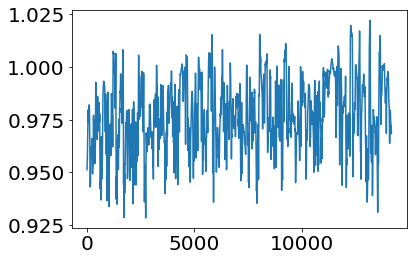

In [53]:
plt.plot(coords_norm)

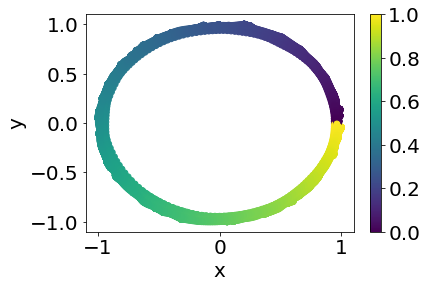

In [54]:
offset_0 = 1 
offset_1 = -1 #-1000

plt.scatter(targets['x'][offset_0:offset_1], 
            targets['y'][offset_0:offset_1], 
            c=targets['phi'][offset_0:offset_1])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# Sklearn models

In [8]:
def MAPE(y, y_pred):
    return (np.linalg.norm(y - y_pred, ord=1, axis=1) / np.linalg.norm(y, ord=1, axis=1)).mean()

def cross_validate(est, X,y, scorer):
    cv_scores = cross_val_score(est, X, y, scoring=scorer, n_jobs=1, cv=5)
    return [cv_scores.mean(), cv_scores.std()]

def train_test_validation(est, X, y, scorer, shuffle=False, test_size=1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    est.fit(X_train, y_train)
    return scorer(est, X_test, y_test)


def evaluate_mi(method, X, y, n_neighbors_mi=50):
    Z = method.fit_transform(X)
    mi_Z = mutual_info_regression(Z, y, discrete_features=False, n_neighbors=n_neighbors_mi, random_state=42)    
    return mi_Z.mean()

r2_scorer = make_scorer(r2_score, greater_is_better=True)
mape_scorer = make_scorer(MAPE, greater_is_better=True)

### Preprocessing

In [9]:
X = data['cadata'].T.copy()
X_s = (data['spdata'].T > 0).astype(int).copy()
# X = np.random.randn(*X.shape)
coords = np.stack([targets['x'].copy(), targets['y']].copy(), -1)
phi = targets['phi'].copy()
coords_ = coords / np.linalg.norm(coords, axis=1)[:,None]

In [10]:
X_sf = softmax(X)
X_rb = normalize_rb(X)
X_n = normalize_features(X)

NameError: name 'softmax' is not defined

In [ ]:
def normalize_features(X):
    return X / (np.linalg.norm(X,axis=-1)[:,None] + 1e-7)

def softmax(X):
    X_e = np.exp(X)
    return X_e / X_e.sum(1)[:,None]

def normalize_rb(X):
    return RobustScaler().fit_transform(X)

In [ ]:
# plt.hist(X_.sum(1))

In [ ]:
def pca_embedding(X, threshold=0.9):
    X_ = X - X.mean(0)[None,:]
    pca = PCA(random_state=42)
    pca.fit(X_)
    n_dim = (np.arange(X.shape[1])[np.cumsum(pca.explained_variance_ratio_) >= threshold])[0]
    pca = PCA(n_components=n_dim, random_state=42)
    Z = pca.fit_transform(X_)
    return Z

In [ ]:
# v_min = np.percentile(X_s.sum(0), 0.1)
# v_max = np.percentile(X_s.sum(0), 99.9)
# neurons_subsample = (X_s.sum(0) > v_min) & (X_s.sum(0) < v_max)
# X_s = X_s[:,neurons_subsample]
# X_s = RobustScaler().fit_transform(X_s)

In [ ]:
# # method = LocallyLinearEmbedding(n_components=2, n_neighbors=300, method='modified', n_jobs=-1, random_state=42)
# method = UMAP(n_components=2, n_neighbors=200, n_jobs=-1, random_state=42)
# Z = method.fit_transform(X_n)

# plt.scatter(Z[:,0], Z[:,1], c=phi)

In [ ]:
# # mi = mutual_info_regression(X, phi, discrete_features=False, n_neighbors=15, random_state=42)
# mi_Z = mutual_info_regression(Z, phi, discrete_features=False, n_neighbors=15, random_state=42)

# plt.hist(mi_Z,bins=15)
# plt.show()

__M22,D1,Circle__  
MI = 1.4 for X softmax (bad embedding)  
MI = 2.53 for X divided by norm  
MI = 2.45 for X original
MI = 2.50 for X scaled

In [ ]:
# plt.hist(mi,bins=15)
# plt.show()

In [ ]:
# est = KNeighborsRegressor(n_neighbors=15, weights='distance', p=1) 
# est = Ridge(random_state=42)
# est_mo = MultiOutputRegressor(est)

In [461]:
# r2_scores = cross_validate(est_mo, X, coords, r2_scorer)
# r2_scores

In [462]:
# r2_scores = cross_validate(est_mo, Z, coords, r2_scorer)
# r2_scores

In [463]:
# r2_scores = cross_validate(est_mo, X_s, coords, r2_scorer)
# r2_scores

In [464]:
# # now on train-test split
# train_test_validation(est_mo, X,coords, r2_scorer, shuffle=False)

 - shuffling increase R2 score on whole data cross-validation or train-test split
 - reconstruction error reduces with time-window moving (Nikita's observation)
 - regression for spdata worse than for cadata
 - regression on cadata better if add PCA


In [465]:
# est_mo.fit(cadata_.T, coords_)
# coords_pred_ = est_mo.predict(cadata_.T)# mae_pred = np.linalg.norm(coords_normalized - coords_pred_, ord=1, axis=1) / np.linalg.norm(coords_normalized, ord=1, axis=1)
# plt.hist(mae_pred, bins=50)
# plt.show()

In [ ]:
# plt.scatter(coords_normalized[:,0], coords_normalized[:,1], alpha=0.1)
# plt.scatter(coords_normalized[:,0][high_mae_mask], coords_normalized[:,1][high_mae_mask], c='r')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('M22, D1, Regression MAPE above 0.6')
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5), dpi=200) 
# plt.plot(np.arange(T),coords_[:,0])
# plt.scatter(np.arange(T)[high_mae_mask], coords_[:,0][high_mae_mask], alpha=0.5, color='r')
# plt.show()

# Cross-validation over time-windows

In [ ]:
dt = 5000
T = int(X.shape[0]) # *0.75
iterator = np.arange(0,T-dt,500)

# est = KNeighborsRegressor(n_neighbors=15, weights='distance', p=1) 
# est = LGBMRegressor(random_state=42)
est = Ridge(random_state=42, fit_intercept=False)
est_mo = MultiOutputRegressor(est)

In [ ]:
len(iterator)

In [ ]:
# scores = Parallel(n_jobs=10, verbose=0)(delayed(train_test_validation)(est_mo, 
#                                                                          X[:i+dt,:], 
#                                                                          coords[:i+dt,:],
#                                                                          mape_scorer, #r2_scorer,
#                                                                          test_size=1000) for i in tqdm_notebook(iterator))
    
# scores = np.array(scores)

In [ ]:
# scores_cv = Parallel(n_jobs=min(len(iterator),N_CPU//2),
#                      verbose=0)(delayed(cross_validate)(est_mo, 
#                                                          pca_embedding(X[i:i+dt,:]), 
#                                                          coords[i:i+dt,:],
#                                                          mape_scorer) for i in tqdm_notebook(iterator))
    
# scores_cv = np.array(scores_cv)

In [ ]:
# plt.plot(scores_cv[:,0])

In [ ]:
method = UMAP(n_components=2, n_neighbors=300, n_jobs=-1, random_state=42)

scores_mi = Parallel(n_jobs=min(len(iterator),N_CPU//2),
                     verbose=0)(delayed(evaluate_mi)(method, 
                                                     X_n[i:i+dt,:], 
                                                     phi[i:i+dt], 
                                                     n_neighbors_mi=15)
                                for i in tqdm_notebook(iterator))
    
scores_mi = np.array(scores_mi)

In [ ]:
plt.plot(iterator, scores_mi)
plt.title(f'MI in timewindow: {dt}, \n Mouse:{mouse}, Day:{day}, {track}')
plt.xlabel('t')
plt.ylabel('MI')
# plt.xticks(ticks=np.arange(len(iterator[::3])), labels=iterator[::3])
plt.show()

In [423]:
np.save(f'scores_mi_{dt}_M{mouse}_D{day}_{track}', scores_mi)

In [424]:
scores_mi_all.append(scores_mi)

In [425]:
# scores_mi_all = []

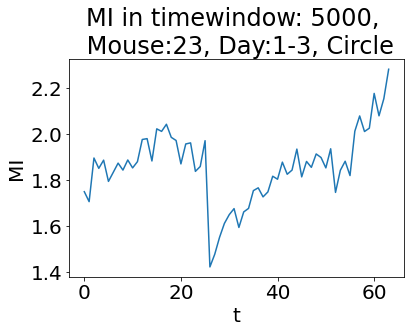

In [426]:
plt.plot(np.concatenate(scores_mi_all))
plt.title(f'MI in timewindow: {dt}, \n Mouse:{mouse}, Day:1-3, {track}')
plt.xlabel('t')
plt.ylabel('MI')
# plt.xticks(ticks=np.arange(len(iterator[::3])), labels=iterator[::3])
plt.show()

In [402]:
# mask = (r2_scores > 0)*(r2_scores_cv[:,0] > 0)
# # mask = np.ones_like(r2_scores).astype(bool) #

# plt.plot(iterator[mask], r2_scores[mask], color='orange')
# plt.plot(iterator[mask], r2_scores_cv[:,0][mask])
# plt.fill_between(x=iterator[mask],
#                  y1=r2_scores_cv[:,0][mask] - r2_scores_cv[:,1][mask],
#                  y2=r2_scores_cv[:,0][mask] + r2_scores_cv[:,1][mask], 
#                  alpha=0.5)

# plt.title(f'Coords prediction \n from neural activity in dt={dt} \n' + f'{track}_M{mouse}_D{day}') # name
# plt.xlabel('time') 
# plt.ylabel('R2')
# plt.show()

# MLP

In [106]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim=2, hidden_dim=256):
        super().__init__() 
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers =  nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.Linear(hidden_dim, output_dim))
        
        
    def forward(self, x):
        x = self.layers(x)
        return x


/media/hpc2_storage/ibulygin/miniconda3/envs/mink/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


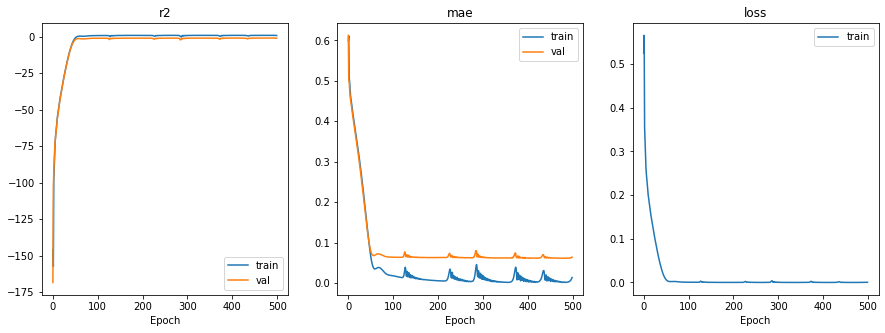

In [63]:
# define data
data_numpy = X.copy()
target_numpy = coords 

# train-test split
N = data_numpy.shape[0]
indexes = np.arange(N)
np.random.shuffle(indexes)
val_ratio = 0.1
split_index = int(val_ratio*N)
val_indexes = indexes[:split_index]
train_indexes = indexes[split_index:]   

data_tensor = torch.from_numpy(data_numpy).cuda().float()
data_val_tensor = data_tensor[val_indexes]
data_train_tensor = data_tensor[train_indexes]

target_tensor = torch.from_numpy(target_numpy).float().cuda()
target_val_tensor = target_tensor[val_indexes]
target_train_tensor = target_tensor[train_indexes]

model = MLP(data_numpy.shape[1], output_dim=target_numpy.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history_train = defaultdict(list)
history_val = defaultdict(list)

for epoch in tqdm_notebook(range(500)):
    opt.zero_grad()
    pred_tensor = model(data_train_tensor)
    loss = criterion(target_train_tensor, pred_tensor)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    
    history_train['r2'].append(r2_score(target_train_tensor.detach().cpu().numpy(), 
                       pred_tensor.detach().cpu().numpy()))
    
    mae = torch.norm(target_train_tensor - pred_tensor, p=1, dim=1)
    history_train['mae'].append(mae.mean().item())
    history_train['loss'].append(loss.item())

    
    # validation
    with torch.no_grad():
        pred_tensor = model(data_val_tensor)

        history_val['r2'].append(r2_score(target_val_tensor.detach().cpu().numpy(), 
                                   pred_tensor.detach().cpu().numpy()))

        mae = torch.norm(target_val_tensor - pred_tensor, p=1, dim=1)
        history_val['mae'].append(mae.mean().item())
    

fig, axes = plt.subplots(nrows=1, ncols=len(history_train), figsize=(15,5))
for i,(k,v) in enumerate(history_train.items()):
    axes[i].plot(v, label='train')
    if k in history_val.keys():
        axes[i].plot(history_val[k], label='val')
    axes[i].set_xlabel('Epoch')
    axes[i].set_title(k)
    axes[i].legend()
plt.show()